In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import matplotlib as mpl

# Script

In [14]:
ofdir = './precision_study/'
dims = [2**i for i in range(1,14)]
xlims = (-10, 10)

In [15]:
for dim in tqdm(dims):
    os.system("./exercise04 -k " + str(dim) + ' -p 0.1' + f" -x {xlims[0]},{xlims[1]}"+ " -o " + ofdir + str(dim))

100%|██████████| 13/13 [02:55<00:00, 13.50s/it]


# Study precision
For the hamiltonian hardcoded in the program we expect to have as eigenvalues $\lambda = (2n+1)$ with $n\in\mathbb{N}$. Thus we can get the relative error for each eigenvalue.

In [26]:
data = np.loadtxt(ofdir + '8192.txt')
eigenstates = data[:-1,:]
eigenvalues = data[-1,:]
x = list(range(len(eigenvalues)))
truevals = [2*i+1 for i in range(len(eigenvalues))]
error = (eigenvalues - truevals)/truevals

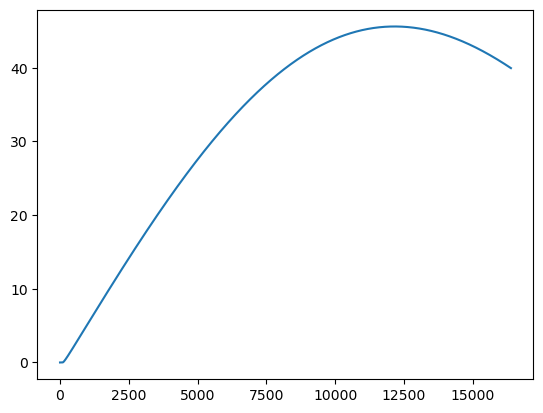

In [28]:
plt.plot(x, error)

In [42]:
tot_truevals = [2*i+1 for i in range(dims[-1])]
errors = []
eigenvalues_dim = []
eigenstates_dim = []
for dim in dims:
    data = np.loadtxt(ofdir + f'{dim}.txt')
    eigenvalues = data[-1,:]
    eigenstates = data[:-1, :]
    eigenvalues_dim.append(eigenvalues)
    eigenstates_dim.append(eigenstates)
    truevals = tot_truevals[:dim]
    error = abs(eigenvalues - truevals)/truevals
    errors.append(error)


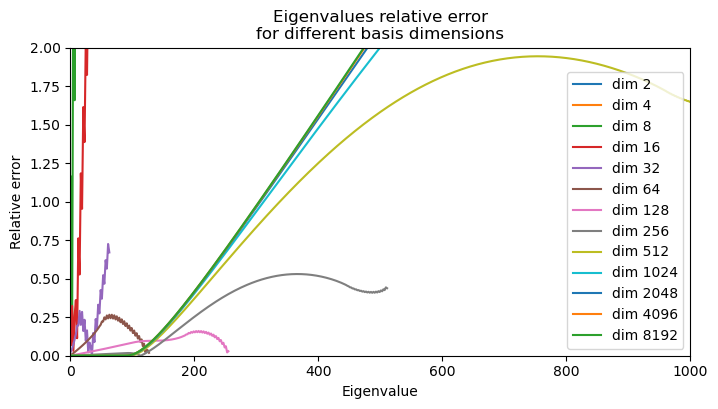

In [43]:
fig, ax = plt.subplots(figsize = (8, 4))
for i, dim in enumerate(dims):
    ax.plot(tot_truevals[:dim], errors[i], label=f'dim {dim}')
ax.legend()
ax.set_xlim(0, 1000)
ax.set_ylim(0, 2)
ax.set_title("Eigenvalues relative error\nfor different basis dimensions")
ax.set_xlabel('Eigenvalue')
ax.set_ylabel('Relative error')
fig.savefig('relative_error.svg')

In [9]:
print('linearity holds till relativ error:', max(errors[-1][250:500]))

linearity holds till relativ error: 590.7909252644204


array([6.46549659e-03, 1.47755565e+01])

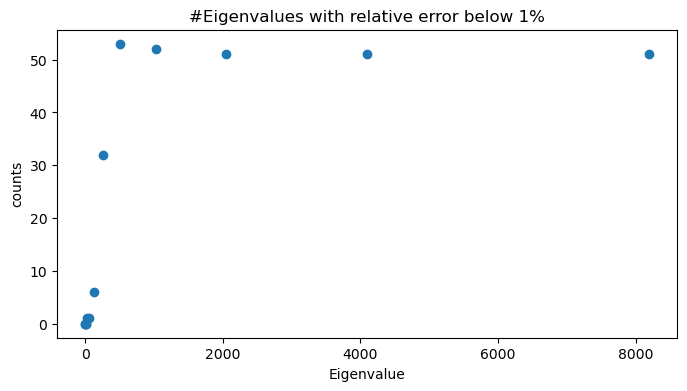

In [49]:
threshold = 0.01
neigval_belowt = [len(error[error < threshold]) for error in errors]

fig, ax = plt.subplots(figsize = (8, 4))
ax.scatter(dims, neigval_belowt)
#ax.set_xscale(mpl.scale.LogScale(axis='x', base=2))
#ax.set_yscale('log')
ax.set_title("#Eigenvalues with relative error below 1%")
ax.set_xlabel('Eigenvalue')
ax.set_ylabel('counts')
fig.savefig('neigenbelow1.svg')
np.polyfit(dims, neigval_belowt, deg=1)

# Study eigenstates

In [98]:
def th_eigenstates(E_level):
    hermite_coeffs = np.zeros(E_level+1)
    hermite_coeffs[-1] = 1
    hermite = np.polynomial.hermite.Hermite(coef=hermite_coeffs, )
    return lambda x: (-1)**E_level*(1/np.pi)**0.25*np.exp(-x**2/2)*hermite(x)

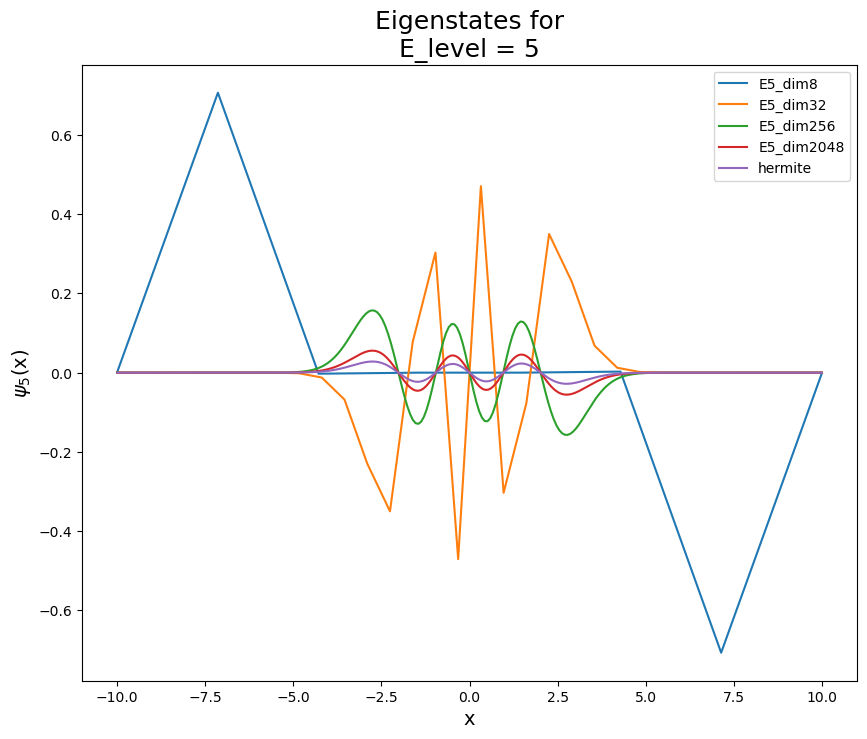

In [110]:

fig, ax = plt.subplots(figsize=(10, 8))
E_level = 5
th_eigenstate = th_eigenstates(E_level)
for i in np.linspace(np.where(np.array(dims)>E_level)[0][0], len(dims), 4, endpoint=False,dtype=np.int16):
    x, step = np.linspace(xlims[0], xlims[1], dims[i], endpoint=True, retstep=True)
    ax.plot(x, eigenstates_dim[i][:, E_level], label=f'E{E_level}_dim{dims[i]}')

x_hermite = np.linspace(xlims[0], xlims[1], 8000, endpoint=True)
hermite_norm = np.sqrt(sum(th_eigenstate(x_hermite)**2))
ax.plot(x_hermite, th_eigenstate(x_hermite)/hermite_norm, label='hermite')
ax.set_title(f'Eigenstates for\nE_level = {E_level}', size=18)
ax.set_xlabel('x', size=14)
ax.set_ylabel(f'$\psi_{E_level}$(x)', size=14)
ax.legend()
fig.savefig('eigenstates.svg')


 58%|█████▊    | 148/256 [00:00<00:00, 1476.84it/s]/tmp/ipykernel_2716/1310244998.py:9: RuntimeWarning: overflow encountered in double_scalars
  hermite_norm = np.sqrt(sum(th_eigenstate(x)**2))
/tmp/ipykernel_2716/1310244998.py:9: RuntimeWarning: overflow encountered in square
  hermite_norm = np.sqrt(sum(th_eigenstate(x)**2))
/media/alberto/Volume/Kubuntu/miniconda3/envs/torch/lib/python3.10/site-packages/numpy/polynomial/hermite.py:895: RuntimeWarning: overflow encountered in multiply
  return c0 + c1*x2
/tmp/ipykernel_2716/1310244998.py:10: RuntimeWarning: invalid value encountered in true_divide
  y_plot.append(sum(abs(th_eigenstate(x)/hermite_norm-eigenstates_dim[i][:,E_level]))/dim)
/media/alberto/Volume/Kubuntu/miniconda3/envs/torch/lib/python3.10/site-packages/numpy/polynomial/hermite.py:894: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/media/alberto/Volume/Kubuntu/miniconda3/envs/torch/lib/python3.10/site-packages/numpy/polynomial/hermite.py:893: Runtim

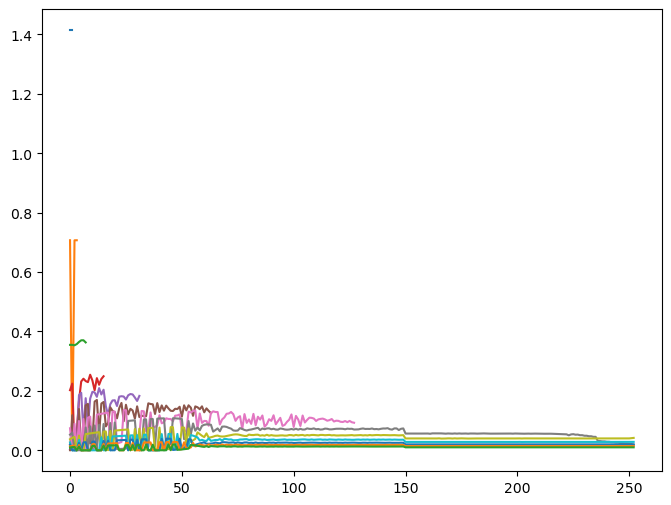

In [115]:
norms = []
fig, ax = plt.subplots(figsize=(8, 6))
for i, dim in enumerate(dims):
    x = np.linspace(xlims[0], xlims[1], dim, endpoint=True)
    x_plot = np.arange(dim)
    y_plot = []
    for E_level in tqdm(x_plot):
        th_eigenstate = th_eigenstates(E_level)
        hermite_norm = np.sqrt(sum(th_eigenstate(x)**2))
        y_plot.append(sum(abs(th_eigenstate(x)/hermite_norm-eigenstates_dim[i][:,E_level]))/dim)
    ax.plot(x_plot, y_plot, label=f'dim {dim}')

In [134]:
ax.legend()
ax.set_xlabel('E_level')
ax.set_ylabel('Norm1')
ax.set_xlim(-1, 257)
ax.set_title('Norm1 of theoretical - experimental eigenstates')
fig.savefig('norm1.svg')

# Check normalization

In [61]:
print('check normalization:')
for i, dim in enumerate(dims):
    print(f'dim {dim}', np.allclose(np.sum(eigenstates_dim[i]**2, axis=0), [1.]))

check normalization:
dim 2 True
dim 4 True
dim 8 True
dim 16 True
dim 32 True
dim 64 True
dim 128 True
dim 256 True
dim 512 True
dim 1024 True
dim 2048 True
dim 4096 True
dim 8192 True
